In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import anndata2ri
#from sklearn.linear_model import LinearRegression

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import least_squares

In [2]:
import warnings
warnings.filterwarnings("ignore")

anndata2ri.activate()
%load_ext rpy2.ipython
sc.settings.verbosity = 0

In [3]:
#ada = sc.datasets.pbmc3k()
#ada

In [4]:
%%R -o labels

library(Seurat)
load(url("https://ndownloader.figshare.com/files/25950872")) 
data.input = data_humanSkin$data # input normalized data matrix
meta = data_humanSkin$meta # a dataframe of cell metadata
cell.use = rownames(meta)[meta$condition == "LS"] # extract the cell names from disease data
data.input = data.input[, cell.use]
meta = meta[cell.use, ]
labels <- as.vector(meta$labels)
#unique(meta$labels) # check the cell labels

R[write to console]: Attaching SeuratObject



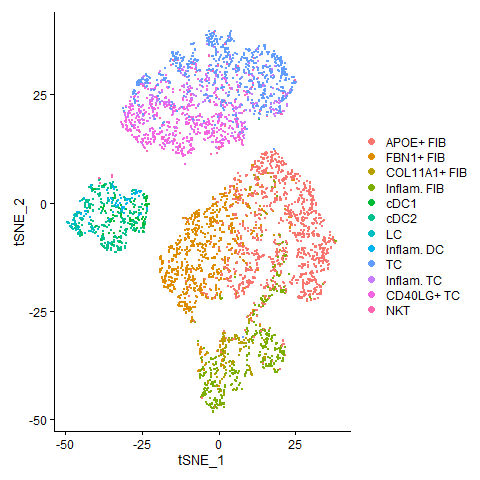

In [5]:
%%R 

set.seed(42)
LS <- CreateSeuratObject(data.input, project = 'LS', meta.data = meta)
Idents(LS) <- LS$labels
LS <- FindVariableFeatures(LS, nfeatures=3000, verbose = F)
LS <- ScaleData(LS, verbose = F) 
LS <- RunPCA(LS, verbose = F)
LS <- RunTSNE(LS)
TSNEPlot(LS)
#VariableFeaturePlot(object = LS)

In [6]:
%%R -o counts -o data -o HVGenes -o Genes -o Cells 

counts <- GetAssayData(LS, slot = 'counts')
data <- GetAssayData(LS, slot = 'data')
Genes <- rownames(counts)
HVGenes <- rownames(GetAssayData(LS, slot = 'scale.data'))
Cells <- colnames(counts)

In [7]:
counts = csr_matrix.toarray(counts)
data = csr_matrix.toarray(data)
data = np.asarray(np.expm1(data), dtype=int)
data

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
ada = AnnData(counts.T)

ada.layers['log1p'] = ada.X
ada.layers['raw'] = data.T
ada.obs['barcodes'] = np.array(Cells)
ada.obs['ident'] = np.array(labels)
ada.var['gene_symbols'] = np.array(Genes)

ada.obs_names = ada.obs['barcodes']
ada.var_names = ada.var['gene_symbols']
#print(ada.isview)
ada = ada[:, ada.var_names.isin(HVGenes)].copy() #Not View

ada

AnnData object with n_obs × n_vars = 5011 × 3000
    obs: 'barcodes', 'ident'
    var: 'gene_symbols'
    layers: 'log1p', 'raw'

In [9]:
#ada.X = ada.layers['raw']

In [10]:
ada.X = ada.layers['log1p']

In [11]:
class Xct_metrics():
    __slots__ = ('genes', 'DB', '_genes_index_DB')
    def __init__(self, adata, specis = 'Human'): #adata: cellA * allgenes
        self.genes = adata.var_names
        self.DB = self.Xct_DB()
        
        #self.adata_use = ada[:, self.subset()]
        #self.subset_index = self.subset()
        #self.subset_genes = adata.var_names[self.subset_index]
        self._genes_index_DB = self.get_index(DB = self.DB)
        #self.mean, self.var, self.disp, self.cv = self.get_metric(adata)
        #self.cv_res = self.chen2016_fit(adata) #dict
    
    def Xct_DB(self, specis = 'Human'):
        if specis == 'Mouse':
            LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Mouse/Mouse-2020-Jin-LR-pairs.csv')
        if specis == 'Human':
            LR = pd.read_csv('https://raw.githubusercontent.com/yjgeno/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
        ligands = LR['ligand'].str.split('_', expand=True)
        ligands.columns = ['lig_A', 'lig_B']
        receptors = LR['receptor'].str.split('_', expand=True)
        receptors.columns = ['rec_A', 'rec_B', 'rec_C']
        LRs = pd.concat([LR[['pathway_name']], ligands, receptors], axis=1)
        del LR

        return LRs
    
    def subset(self):
        genes = np.ravel(self.DB.iloc[:, 1:].values) #['lig_A', 'lig_B', 'rec_A', 'rec_B', 'rec_C']
        genes = np.unique(genes[genes != None])
        genes_use = self.genes.intersection(genes)
            
        return [list(self.genes).index(g) for g in genes_use]    #index in orig adata
    
    def get_index(self, DB):
        g_LRs = DB.iloc[:, 1:6].values #['lig_A', 'lig_B', 'rec_A', 'rec_B', 'rec_C']
        gene_list = [None] + list(self.genes) #LR genes intersect with DB

        gene_index = np.zeros(len(np.ravel(g_LRs)), dtype = int)
        for g in gene_list:
            g_index = np.asarray(np.where(np.isin(np.ravel(g_LRs), g)))
            if g_index.size == 0:
                continue
            else:
                for i in g_index:
                    gene_index[i] = gene_list.index(g) 
        genes_index_DB = np.array(gene_index).reshape(g_LRs.shape) #gene index refer to subset adata var + 1
        
        return genes_index_DB


    def get_metric(self, adata, verbose = False): #require normalized data
        data_norm = csr_matrix.toarray(adata.X) if isinstance(adata.X, scipy.sparse.csr.csr_matrix) else adata.X#.copy()
        if verbose:
            print('(cell, feature):', data_norm.shape)
        
        if (data_norm % 1 != 0).any(): #check space: True for log (float), False for counts (int)
            mean = np.mean(data_norm, axis = 0)
            var = np.var(data_norm, axis = 0)
            mean[mean == 0] = 1e-12
            dispersion = var / mean    
            cv = np.sqrt(var) / mean

            return mean, var, dispersion, cv
        else:
            raise ValueError("require log data")
    
    def chen2016_fit(self, adata, plot = False, verbose = False): #require raw data 
        data_raw = adata.layers['raw'] #.copy()
        if (data_raw % 1 != 0).any():
            raise ValueError("require counts (int) data")
        else:
            mean_raw = np.mean(data_raw, axis = 0)
            var_raw = np.var(data_raw, axis = 0)
            mean_raw[mean_raw == 0] = 1e-12
            cv_raw = np.sqrt(var_raw) / mean_raw
        
        xdata_orig = mean_raw #raw
        ydata_orig = np.log10(cv_raw) #log   
        rows = len(xdata_orig) #features

        r = np.invert(np.isinf(ydata_orig)) # filter -Inf
        ydata = ydata_orig[r] #Y
        xdata = xdata_orig[r] #X

        #poly fit: log-log
        z = np.polyfit(np.log10(xdata), ydata, 2) 

        def predict(z, x):
            return z[0]*(x**2) + z[1]*x + z[2]

        xSeq_log = np.arange(min(np.log10(xdata)), max(np.log10(xdata)), 0.005) 
        ySeq_log = predict(z, xSeq_log)  #predicted y

        #start point for fit
        #plt.hist(np.log10(xdata), bins=100)
        def h(i):
            a = np.log10(xdata) >= (xSeq_log[i] - 0.05)
            b = np.log10(xdata) < (xSeq_log[i] + 0.05)
            return np.sum((a & b))

        gapNum = [h(i) for i in range(0, len(xSeq_log))] #density histogram of xdata
        cdx = np.nonzero(np.array(gapNum) > rows*0.005)[0] #start from high density bin

        xSeq = 10 ** xSeq_log 

        #end pointy for fit
        yDiff = np.diff(ySeq_log, 1) #a[i+1] - a[i]
        ix = np.nonzero((yDiff > 0) & (np.log10(xSeq[0:-1]) > 0))[0] # index of such (X, Y) at lowest Y

        if len(ix) == 0:
            ix = len(ySeq_log) - 1 # use all
        else:
            ix = ix[0]

        #subset data for fit
        xSeq_all = 10**np.arange(min(np.log10(xdata)), max(np.log10(xdata)), 0.001) 
        xSeq = xSeq[cdx[0]:ix]
        ySeq_log = ySeq_log[cdx[0]:ix]

        if verbose:
            #print(ix, cdx[0])
            print('{} (intervals for fit) / {} (filtered -Inf) / {} (original) features for the fit'.format(ix-cdx[0], len(ydata), len(ydata_orig)))

        #lst fit
        def residuals(coeff, t, y):
            return y - 0.5 * (np.log10(coeff[1]/t + coeff[0])) # x: raw mean y:log(cv)

        x0 = np.array([0, 1], dtype=float) # initial guess a=0, b=1
        model = least_squares(residuals, x0, loss='soft_l1', f_scale= 0.01, args=(xSeq, ySeq_log))

        def predict_robust(coeff, x):
            return 0.5 * (np.log10(coeff[1]/x + coeff[0]))

        ydataFit = predict_robust(model.x, xdata_orig) #logCV

        def cv_diff(obs_cv, fit_cv): 
            obs_cv[obs_cv == 0] = 1e-12
            diff = np.log10(obs_cv) - fit_cv
            return diff #{key: v for key, v in zip(self.genes, diff)} 

        if plot:
            y_predict = predict_robust(model.x, xSeq) 
            plt.figure(figsize=(6, 5), dpi=80)   
            plt.scatter(np.log10(xdata), ydata, s=3, marker='o') # orig
            plt.plot(np.log10(xSeq), ySeq_log, c='black', label='poly fit') # poly fit
            plt.plot(np.log10(xSeq), y_predict, label='robust lsq', c='r') # robust nonlinear

            #ind = list(res[res['padj'] < fdr].index)[:ngenes] # index for filtered xdata, ydata
            #for n, i in zip(['CCL19', 'CCR7', 'CXCL12', 'CXCR4'], [371, 388, 592, 598]):
            #   plt.annotate(n, xy = (np.log10(xdata)[i], ydata[i]), xytext = (np.log10(xdata)[i]+1, ydata[i]+0.5),
            #                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
            plt.xlabel('log10(mean)')
            plt.ylabel('log10(CV)')
            plt.legend(loc='lower left')
            plt.show()
        
        #obs_cv = self.cv.copy()
        diff = cv_diff(cv_raw, ydataFit)
        return diff #log CV difference
    

In [12]:
skin = Xct_metrics(ada)
type(skin)

__main__.Xct_metrics

In [13]:
skin.DB

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C
0,TGFb,TGFB1,None,TGFbR1,R2,None
1,TGFb,TGFB2,None,TGFbR1,R2,None
2,TGFb,TGFB3,None,TGFbR1,R2,None
3,TGFb,TGFB1,None,ACVR1B,TGFbR2,None
4,TGFb,TGFB1,None,ACVR1C,TGFbR2,None
...,...,...,...,...,...,...
2000,TIGIT,TIGIT,None,MGI:107741,None,None
2001,VCAM,ITGA4,ITGB1,VCAM1,None,None
2002,VCAM,ITGA9,ITGB1,VCAM1,None,None
2003,VCAM,ITGA4,ITGB7,VCAM1,None,None


In [14]:
skin._genes_index_DB

array([[   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       ...,
       [   0,    0, 2670,    0,    0],
       [   0,    0, 2670,    0,    0],
       [   0,    0,    0,    0,    0]])

918 (intervals for fit) / 3000 (filtered -Inf) / 3000 (original) features for the fit


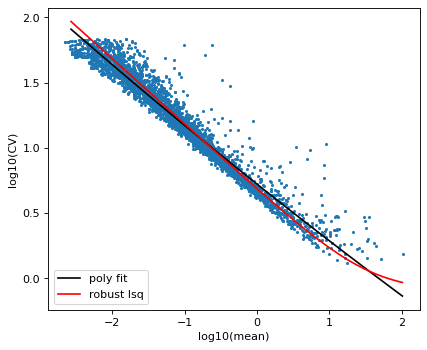

array([ 0.05336176,  0.02588783, -0.11419019, ..., -0.20103266,
       -0.21111084,  0.01174273])

In [15]:
skin.chen2016_fit(ada, plot = True, verbose = True)

In [16]:
class Xct(Xct_metrics):

    def __init__(self, adata, CellA, CellB, pmt = False):
        Xct_metrics.__init__(self, adata)
        self._metric_names = ['mean', 'var', 'disp', 'cv', 'cv_res']
        ada_A = adata[adata.obs['ident'] == CellA, :].copy()
        ada_B = adata[adata.obs['ident'] == CellB, :].copy()
        
        self._metric_A = np.vstack([self.get_metric(ada_A), self.chen2016_fit(ada_A)]) #len 5
        self._metric_B = np.vstack([self.get_metric(ada_B), self.chen2016_fit(ada_B)])
        
        if not pmt:
            self.ref = self.fill_metric()
            self.genes_index = self.get_index(DB = self.ref)
       
        del ada_A, ada_B
               
    def fill_metric(self, ref_obj = None, verbose = False):
        if ref_obj is None:
            genes_index = self._genes_index_DB
        else:
            #if isinstance(ref_obj, Xct):
            genes_index = ref_obj.genes_index
        #print(genes_index)
        
        index_L = genes_index[:, :2]
        index_R = genes_index[:, 2:]

        df = pd.DataFrame()

        for metric_A, metric_B, metric in zip(self._metric_A, self._metric_B, self._metric_names):
            filled_L = []
            filled_R = []
            for i in np.ravel(index_L):
                if i == 0:
                    filled_L.append(0) #none expression
                else:
                    filled_L.append(np.round(metric_A[i-1], 11))
            filled_L = np.array(filled_L, dtype=float).reshape(index_L.shape)

            for i in np.ravel(index_R):
                if i == 0:
                    filled_R.append(0)
                else:
                    filled_R.append(np.round(metric_B[i-1], 11))
            filled_R = np.array(filled_R, dtype=float).reshape(index_R.shape)

            filled = np.concatenate((filled_L, filled_R), axis=1)
            result = pd.DataFrame(data = filled, columns = [f'{metric}_L1', f'{metric}_L2', 
                                                             f'{metric}_R1', f'{metric}_R2', f'{metric}_R3'])
            df = pd.concat([df, result], axis=1)
        
        #DB = skin.DB.reset_index(drop = True, inplace = False) 
        
        
        if ref_obj is None:
            df = pd.concat([self.DB, df], axis=1) # concat 1:1 since sharing same index
            mask1 = (df['mean_L1'] > 0) & (df['mean_R1'] > 0) # filter 0 for first LR
            df = df[mask1]

            pattern_orig = df.iloc[:, 1:6].isnull() #L-R complex
            pattern_obs = df.iloc[:, 6:11].isin([0]) #mean expression
            mask2 = (pattern_orig.values == pattern_obs.values).all(axis=1) # for LR complex
            df = df[mask2]
            
        else: 
            ref_DB = self.DB.iloc[ref_obj.ref.index, :].reset_index(drop = True, inplace = False) #match index
            df = pd.concat([ref_DB, df], axis=1)
            df.set_index(pd.Index(ref_obj.ref.index), inplace = True)
            
        
        df.replace(to_replace={0:None}, inplace = True) #for geo mean
        
        for i, name in zip(range(6, 31, 5), self._metric_names):
            lig = df.iloc[:, i:i+2]
            rec = df.iloc[:, i+2:i+5]
            if i < 26:
                df[f'{name}_L'] = np.asarray(np.power(lig.prod(axis=1), 1./lig.notna().sum(1))) #L geomean: Kth root
                df[f'{name}_R'] = np.asarray(np.power(rec.prod(axis=1), 1./rec.notna().sum(1))) #R
            else:
                df[f'{name}_L'] = np.asarray(lig.sum(axis = 1, skipna = True))
                df[f'{name}_R'] = np.asarray(rec.sum(axis = 1, skipna = True))
        
        #df.to_csv('df.csv', index=False)
        if verbose:
            print('Selected {} LR pairs'.format(df.shape[0]))

        return df
    
    
    def score(self, ref_DB = None, method = 0, a = 1):
        if ref_DB is None:
            ref_DB = self.ref.copy()
        S0 = ref_DB['mean_L'] * ref_DB['mean_R'] 
        S0 /= np.percentile(S0, 80) 
        S0 = S0/(0.5 + S0)

        if method == 0:
            return S0  
        if method == 1:
            S = (ref_DB['mean_L']**2 + a*ref_DB['var_L'])*(ref_DB['mean_R']**2 + a*ref_DB['var_R'])
            S = S/(0.5 + S)
        if method == 2:
            S = ref_DB['disp_L'] * ref_DB['disp_R']
        if method == 3:
            S = ref_DB['cv_L'] + a*ref_DB['cv_R']
        if method == 4:
            ref_DB['cv_res_L'][ref_DB['cv_res_L'] < 0] = 0
            S = abs(ref_DB['cv_res_L'] * ref_DB['cv_res_R'])
            S = S/(0.5+S) + a*S0
            #S = S0 / (S/(0.5+S))
        if method == 5:
            S = ref_DB['cv_res_L'] + a*ref_DB['cv_res_R']

        return S #.astype(float)
    
  

In [17]:
def scores(adata, ref_obj, method = 1, n = 100):
    result = []
    temp = adata.copy()
    
    for _ in range(n):
        labels_pmt = np.random.permutation(temp.obs['ident']) #pmt gloablly
        temp.obs['ident'] = labels_pmt
        #ada_pmt = pmt(adata)
        pmt_obj = Xct(temp, 'Inflam. FIB', 'Inflam. DC', pmt =True)
        df_pmt = pmt_obj.fill_metric(ref_obj = ref_obj)
        result.append(pmt_obj.score(ref_DB = df_pmt, method = method))
    
    return np.array(result).T

In [18]:
def pmt_test(orig_score, scores, p = 0.05):
    enriched_i, pvals, counts = ([] for _ in range(3))
    for i, dist in enumerate(scores):
        count = sum(orig_score[i] > value for value in dist)
        pval = 1- count/len(dist)
        pvals.append(pval)
        counts.append(count)
        
        if pval < p:
            enriched_i.append(i)           
    
    return enriched_i, pvals, counts

### test

In [19]:
s1 = Xct(ada, 'Inflam. FIB', 'Inflam. DC')
df1 = s1.fill_metric()
df1

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C,mean_L1,mean_L2,mean_R1,mean_R2,...,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
93,GDF,GDF10,None,ACVR1B,ACVR2A,None,0.00325945,None,0.0301925,0.0942207,...,0.003259,0.053336,0.005131,0.113562,1.574328,2.129173,21.977348,6.318211,-0.283582,0.110906
121,ACTIVIN,INHBA,None,ACVR1B,ACVR2A,None,0.0455448,None,0.0301925,0.0942207,...,0.045545,0.053336,0.083606,0.113562,1.835696,2.129173,6.348641,6.318211,-0.146218,0.110906
645,CCL,CCL19,None,CCR7,None,None,1.73826,None,1.68851,None,...,1.738264,1.688513,5.539169,1.941579,3.186609,1.149875,1.353962,0.825226,0.660159,-0.005376
646,CCL,CCL21,None,CCR7,None,None,0.0508268,None,1.68851,None,...,0.050827,1.688513,0.100430,1.941579,1.975917,1.149875,6.235023,0.825226,-0.063040,-0.005376
711,CXCL,CXCL12,None,CXCR4,None,None,1.42576,None,1.35605,None,...,1.425765,1.356051,2.725715,1.514931,1.911756,1.117163,1.157957,0.907654,0.295925,-0.035804
806,TNF,TNF,None,TNFRSF1B,None,None,0.00311728,None,0.372519,None,...,0.003117,0.372519,0.004694,0.689931,1.505661,1.852070,21.977388,2.229741,-0.283582,0.107562
825,CD137,TNFSF9,None,TNFRSF9,None,None,0.00580778,None,0.350037,None,...,0.005808,0.350037,0.009629,0.498938,1.657863,1.425387,16.895428,2.017946,-0.160756,-0.155219
1037,NT,BDNF,None,NTRK2,None,None,0.00938566,None,0.024446,None,...,0.009386,0.024446,0.016305,0.027285,1.737243,1.116143,13.604974,6.757027,-0.094830,-0.338065
1572,LAMININ,LAMB1,None,SV2B,None,None,0.192922,None,0.0157612,None,...,0.192922,0.015761,0.356616,0.019873,1.848501,1.260899,3.095419,8.944272,-0.019347,-0.338065
1573,LAMININ,LAMB2,None,SV2B,None,None,1.02716,None,0.0157612,None,...,1.027162,0.015761,1.343442,0.019873,1.307917,1.260899,1.128420,8.944272,-0.030466,-0.338065


In [20]:
isinstance(s1, Xct)

True

In [21]:
s1.genes_index

array([[ 910,    0,   34,   36,    0],
       [1163,    0,   34,   36,    0],
       [ 372,    0,  389,    0,    0],
       [ 375,    0,  389,    0,    0],
       [ 593,    0,  599,    0,    0],
       [2534,    0, 2541,    0,    0],
       [2549,    0, 2545,    0,    0],
       [ 213,    0, 1811,    0,    0],
       [1315,    0, 2432,    0,    0],
       [1316,    0, 2432,    0,    0],
       [1317,    0, 2432,    0,    0],
       [2236,    0, 1968,    0,    0]])

In [22]:
s1.score(method=0)

93      0.004813
121     0.063298
645     0.987901
646     0.704789
711     0.981747
806     0.031293
825     0.053526
1037    0.006342
1572    0.077990
1573    0.310516
1577    0.130846
1991    0.016351
dtype: float64

In [23]:
#s1.get_index(DB = s1.ref)

### 0

In [24]:
np.random.seed(1)

orig_score0 = np.asarray(s1.score(method=0))
pmt_scores0 = scores(ada, s1, n=10)
pmt_scores0.shape

(12, 10)

In [25]:
enriched, pvals, counts = pmt_test(orig_score0, pmt_scores0)
enriched, counts

([2, 3, 4], [0, 4, 10, 10, 10, 0, 9, 0, 5, 5, 6, 6])

In [26]:
df_enriched = df1.iloc[enriched, :]
df_enriched

,pathway_name,lig_A,lig_B,rec_A,rec_B,rec_C,mean_L1,mean_L2,mean_R1,mean_R2,...,mean_L,mean_R,var_L,var_R,disp_L,disp_R,cv_L,cv_R,cv_res_L,cv_res_R
645,CCL,CCL19,None,CCR7,None,None,1.73826,None,1.68851,None,...,1.738264,1.688513,5.539169,1.941579,3.186609,1.149875,1.353962,0.825226,0.660159,-0.005376
646,CCL,CCL21,None,CCR7,None,None,0.0508268,None,1.68851,None,...,0.050827,1.688513,0.100430,1.941579,1.975917,1.149875,6.235023,0.825226,-0.063040,-0.005376
711,CXCL,CXCL12,None,CXCR4,None,None,1.42576,None,1.35605,None,...,1.425765,1.356051,2.725715,1.514931,1.911756,1.117163,1.157957,0.907654,0.295925,-0.035804


### 1

In [ ]:
np.random.seed(4)

orig_score1 = np.asarray(s1.score(method=1))
pmt_scores1 = scores(ada, s1, method=1, n=10)
pmt_scores1.shape

In [ ]:
enriched, pvals, counts = pmt_test(orig_score1, pmt_scores1)
enriched, counts

In [ ]:
df_enriched = df1.iloc[enriched, :]
df_enriched

### 4

In [ ]:
np.random.seed(42)

orig_score4 = np.asarray(s1.score(method=4))
pmt_scores4 = scores(ada, s1, method=4, n=10)
pmt_scores4.shape

In [ ]:
enriched, pvals, counts = pmt_test(orig_score4, pmt_scores4)
enriched, counts

In [ ]:
df_enriched = df1.iloc[enriched, :]
df_enriched